In [1]:
from grid_world import *
from stage2skeletonv3 import *
import random as rd

# 4 neighbours - statespace 11, 8 neighbours - 15
statespace_size = 11 # 3 (x,y) coords + a boolean (reached_a) + 8 neighbourhood booleans (presence of neighbours of opposite type - different reached_a)

gamma = 0.95
# epsilon = 1.0
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

def TD_target(reward, gamma, done, qMax):
    # done was an arg in skeleton
#   target = reward + gamma*(1-done)*qMax
    target = reward + gamma*(1-done)*qMax
    return target

action_set = {0: 'n', 1: 'e', 2: 's', 3: 'w'}

from collections import deque
from IPython.display import clear_output

epochs = 4000
mem_size = 2000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 100
h = 0
sync_freq = 500
j=0
losses=[]
rewards=[]
collisions_lst = []
a_b_switches_lst = []
successes=0

model = prepare_torch()

n = 5
m = 5

num_agents = 4

total_a_b_switches = 0
collisions = 0

# initialise all configs and agents to optimize training performance

loc_as = []
loc_bs = []
agents_each_epoch = []
gws = []

for i in range(epochs):

    loc_a = (rd.randint(0,n-1), rd.randint(0,m-1))
    loc_as.append(loc_a)
    loc_b = (rd.randint(0,n-1), rd.randint(0,m-1))

    # ensuring loc_b and loc_a aren't equal
    while loc_b == loc_a:
        loc_b = rd.randint(0,n-1), rd.randint(0,m-1)
    
    loc_bs.append(loc_b)
    agents = init_agents( num_agents, loc_a, loc_b )
    agents_each_epoch.append( agents )
    # agents_each_epoch.append( init_agents_random( n, m, num_agents, loc_a ) )

    gws.append( GridWorld(n, m, loc_a, loc_b, agents) )

# main loop

for i in range(epochs):

    loc_a = loc_as[i]
    loc_b = loc_bs[i]

    agents = agents_each_epoch[i]

    # a_b_switches = {}
    # for agent in agents:
    #     a_b_switches[agent.id] = 0

    gw = gws[i]

    steps = 0
    loop = True
    episode_reward = 0
    epoch_a_b_switches = 0
    epoch_collisions = 0

    while loop and (steps < max_moves):

        # # change loop_agents to random order
        loop_agents = agents

        # rd.shuffle(loop_agents)
        
        for agent in loop_agents:

            # print(steps)
            init_reached_a = agent.reached_a

            state1 = gw.get_np_state_for_agent(agent)
            steps += 1
            j += 1
            qvals = get_qvals(state1)

            if (rd.random() < epsilon):
                action_ = rd.randint(0,3)
            else:
                action_ = np.argmax(qvals)
            
            action = action_set[action_]
            
            reward = gw.attempt_action_for_agent(agent, action)

            state2 = gw.get_np_state_for_agent(agent)

            episode_reward += reward

            if agent.reached_a != init_reached_a:
                epoch_a_b_switches += 1

            # if we consider pickup and dropoff as terminal condition - we dont - because agents need to learn infinite behavior
            # done = True if (a_b_switches[agent.id] >= 2) else False # both pickup and delivery at least once
            
            # if we consider 1 collision 
            # or num_steps over 25
            # as a terminal condition
            done = False
            if (agent.num_collisions > 0) or (agent.num_steps > 25):
                done = True
                loop = False

            exp = (state1, action_, reward, state2, done)
            replay.append(exp)

            if (len(replay) > batch_size) and (j % 10 == 0):

                minibatch = rd.sample(replay, batch_size)
                states = [s1 for (s1,_,_,_,_) in minibatch]
                actions = [a for (_,a,_,_,_) in minibatch]
                targets = [TD_target(r, gamma, done, get_maxQ(s2)) for (_,_,r,s2,_) in minibatch]
                current_loss = train_one_step(states, actions, targets, gamma)
                losses.append(current_loss)
                print(i, "a_b_switches:", total_a_b_switches, " loss:", current_loss, "total collisions:", collisions, "epoch_collisions:", epoch_collisions)
                print(f"episode_reward: {episode_reward} steps: {steps} epoch_a_b_switches: {epoch_a_b_switches} epsilon: {epsilon}")
                print()
                clear_output(wait=True)

            if j % sync_freq == 0:
                update_target()
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        epoch_collisions = sum([agent.num_collisions for agent in loop_agents])

        # final - pending work
        # if (steps > max_moves):
        # debug
        # if (episode_reward >= 150) or (episode_reward <= -2000):
        # if ( epoch_successes >= 8 ) or (steps > max_moves) \
        # or ( epoch_collisions >= 1 ) :
        #     rewards.append(episode_reward)  
        #     loop = False
        #     steps = 0
        #     break

        if steps > max_moves:
            rewards.append(episode_reward)
            loop = False
            steps = 0
            break
        
        # print(i)
        # clear_output(wait=True)

    total_a_b_switches += epoch_a_b_switches

    for agent in agents:
        collisions += epoch_collisions
    
    collisions_lst.append(epoch_collisions)
    a_b_switches_lst.append(epoch_a_b_switches)
    
    # clear_output(wait=True)  

print(f"total steps in training: {j}, total collisions: {collisions}, total successes: {successes}")

### Runner skeleton
# 
# Runner should probably have agent-specific choose_action logic 
# 
# for each epoch, start with a gw
# for this gw, per each agent (in random order)...
#   get agent-specific "state" as state1 from gw (should have encoded neigbourhood values)
#   get qvals
#   get max qval and take the corresponding action for this agent
#   use reward returned by attempt_action...() to construct new state (state2) and store it back in the deque
#   state1 = state2, repeat for next random agent
# 
#

# class Runner:

#     def __init__(self, gw, agents):

#         self.gw = gw
#         self.agents = agents

#     def run(self):
#        pass


total steps in training: 322184, total collisions: 7568, total successes: 0


In [2]:
print(f"total steps in training: {j}, total collisions: {collisions}, total successes: {successes}")
print(f"latest loss: {losses[-1]}")

total steps in training: 322184, total collisions: 7568, total successes: 0
latest loss: 92.85971069335938


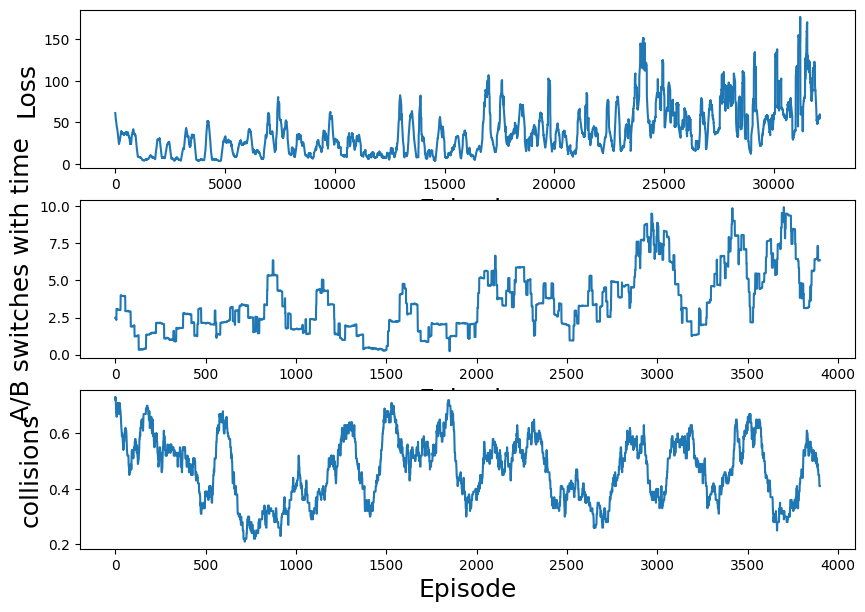

In [3]:
def moving_averages(arr, window_size):
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

from matplotlib import pylab as plt

# plt.xlabel("Episode",fontsize=22)
# plt.ylabel("Loss",fontsize=22)
# plt.plot(np.array(losses))
# plt.figure(figsize=(10,7))

_, axs = plt.subplots(3, 1, figsize = (10,7))

# axs[0].plot(np.array(losses))
# axs[0].set_xlabel("Episode",fontsize=18)
# axs[0].set_ylabel("Loss",fontsize=18)

axs[0].plot(np.array(moving_averages(losses, 100)))
axs[0].set_xlabel("Episode",fontsize=18)
axs[0].set_ylabel("Loss",fontsize=18)

# axs[1].set_xlabel("Episode", fontsize=18)
# axs[1].set_ylabel("A/B switches", fontsize=18)
# axs[1].plot(np.array(a_b_switches_lst))

axs[1].set_xlabel("Episode", fontsize=18)
axs[1].set_ylabel("A/B switches with time", fontsize=18)
axs[1].plot(np.array(moving_averages(a_b_switches_lst, 100)))

# axs[2].set_xlabel("Episode", fontsize=18)
# axs[2].set_ylabel("collisions", fontsize=18)
# axs[2].plot(np.array(collisions_lst))

axs[2].set_xlabel("Episode", fontsize=18)
axs[2].set_ylabel("collisions", fontsize=18)
axs[2].plot(moving_averages(collisions_lst, 100))

plt.show()

In [5]:
print(losses[-1])

96.3254165649414


In [4]:
def test_once(model, loc_a, loc_b, display=True):

    n = 5
    m = 5

    max_steps = 25

    # 1st agent always begins at B
    agents = init_agents(4, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    focal_agent_idx = 0

    states_ = [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]
    states = [torch.from_numpy(state_).float() for state_ in states_]

    if display:
        print("initial state:")
        gw.display()
        print("focal agent is", agents[focal_agent_idx].id)

    for s in range( (len(agents)*25) + 1 ):

        for idx in range(len(agents)):

                qval = model(states[idx])
                qval_ = qval.data.numpy()
                action_ = np.argmax(qval_)
                action = action_set[action_]

                rew = gw.attempt_action_for_agent(agents[idx], action)

                if display:
                    print(f"agent {agents[idx].id} took action {action} and got rewarded {rew}")
                    print(gw.display())
                
                state_ = gw.get_np_state_for_agent(agents[idx]).reshape(1, statespace_size)
                state = torch.from_numpy(state_).float()
                states[idx] = state
        
        # whichever if condition is met first will return
        if (agents[focal_agent_idx].num_steps > max_steps):
            if display:
                print("test unsuccessful - too many steps")
            return False
        
        if (agents[focal_agent_idx].num_collisions > 0):
            if display:
                print("test unsuccessful - focal agent collided with an agent of the opposite type")
            return False

        if (agents[focal_agent_idx].reached_a):
            if display:
                print(f"test success - focal agent {agents[focal_agent_idx].id} reached A without collisions in under 25 steps")
            return True

    # ideally this line must never execute - if conditions should handle everything
    return False


In [5]:
loc_a = ( rd.randint(0,4), rd.randint(0,4) )
loc_b = ( rd.randint(0,4), rd.randint(0,4) )

test_once(model, loc_a, loc_b, True)

initial state:
 ----------------
|           B    |
|  A             |
|                |
|                |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
1 (0, 3) False | 2 (0, 3) False | 4 (0, 3) False | 3 (1, 0) True | 
focal agent is 1
agent 1 took action w and got rewarded -1
 ----------------
|       *1  B    |
|  A             |
|                |
|                |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
1 (0, 2) False | 2 (0, 3) False | 4 (0, 3) False | 3 (1, 0) True | 
None
agent 2 took action w and got rewarded -1
 ----------------
|       *2  B    |
|  A             |
|                |
|                |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in

False

In [7]:
def test_stats(model):
  max_games = 1000
  wins = 0
  for i in range(max_games):
      
      loc_a = ( rd.randint(0,4), rd.randint(0,4) )
      loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      win = test_once(model, loc_a, loc_b, display=False)
      if win:
          wins += 1

  win_perc = float(wins) / float(max_games)
  print("Games played: {0}, # of wins: {1}".format(max_games,wins))
  print("Win percentage: {}".format(win_perc))


test_stats(model)

Games played: 1000, # of wins: 184
Win percentage: 0.184
